In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
torch.set_default_dtype(torch.float32)

In [2]:
df = pd.read_csv("data/AirPassengers.csv", parse_dates=['Month'], dtype=np.float32)
df.head()

,Month,#Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


<Axes: xlabel='Month'>

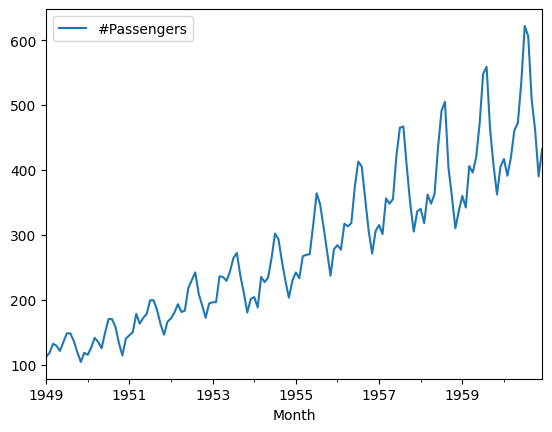

In [3]:
df.plot(x="Month", y='#Passengers')

In [4]:
def make_training_data(ylist, na):
    Xdata = []
    Ydata = []
    for k in range(na, len(ylist)):  # skip the first few indexes
        Xdata.append(ylist[k - na:k])
        Ydata.append(ylist[k])
    return torch.tensor(Xdata), torch.tensor(Ydata)

def make_training_data_with_history(ylist, na, nhist):
    Xdata = []
    Ydata = []
    Hdata = []
    for k in range(na + nhist, len(ylist)):  # skip the first few indexes
        Hdata.append(ylist[k-na-nhist:k-na])
        Xdata.append(ylist[k - na:k])
        Ydata.append(ylist[k])
    return torch.tensor(Xdata), torch.tensor(Ydata), torch.tensor(Hdata)

class SimpleDataSet(Dataset):
    def __init__(self, x_data, y_data, transform=None, target_transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        x = self.x_data[idx, :]
        y = self.y_data[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y

n_ar = 5
n_hist = 3
batch_size = 1.0 # percentage
test_size = 0.3 # percentage
Xdata, Ydata, Hdata = make_training_data_with_history(df["#Passengers"].values, n_ar, n_hist)
Xtrain, Xval, Ytrain, Yval, Htrain, Hval = train_test_split(Xdata, Ydata, Hdata, test_size=test_size, shuffle=True)

n_samples = len(Ydata)
n_batch = round(batch_size * n_samples)
assert n_batch > 1, "Batch normalization of the model requires batch size greater than 1!"
train_dl = DataLoader(SimpleDataSet(Xtrain, Ytrain), batch_size=n_batch, shuffle= True)
val_dl = DataLoader(SimpleDataSet(Xval, Yval), batch_size=n_batch, shuffle= True)

C:\Users\mralp\AppData\Local\Temp\ipykernel_17020\3079688161.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(Xdata), torch.tensor(Ydata), torch.tensor(Hdata)


In [5]:
class Network(nn.Module):
    """MLP with series of Forward-BatchNorm-Relu layers."""
    def __init__(self, n_hidden_nodes_list=[1, 32, 1]):
        super(Network, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(node_in, node_out) for node_in, node_out in
                                    zip(n_hidden_nodes_list[:-1], n_hidden_nodes_list[1:])])
        self.batchnorm_layers = nn.ModuleList([nn.BatchNorm1d(node_in) for node_in in n_hidden_nodes_list[1:]])
        self.lastlayer = nn.Linear(n_hidden_nodes_list[-1], 1)

    def forward(self, x):
        for layer_idx, (layer, bn) in enumerate(zip(self.layers, self.batchnorm_layers)):
            x = torch.relu(bn(layer(x)))
        y = self.lastlayer(x)[:, 0]
        return y

# Create model
model = Network([n_ar,32])
print(f"model structure: {model}\n\n")

model structure: Network(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=32, bias=True)
  )
  (batchnorm_layers): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lastlayer): Linear(in_features=32, out_features=1, bias=True)
)




In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model_lstm to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss = loss.item()
    return loss


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [7]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 7001
loss_train = []
loss_val = []
for t in range(epochs):
    loss_t = train_loop(train_dl, model, loss_fn, optimizer)
    loss_v = test_loop(val_dl, model, loss_fn)
    loss_train.append(loss_t)
    loss_val.append(loss_v)

    if t % 500 == 0:
        print(f"Epoch {t+1}, Train loss = {loss_t}, Validation loss = {loss_v} \n-------------------------------")

Epoch 1, Train loss = 93987.828125, Validation loss = 103204.828125 
-------------------------------
Epoch 501, Train loss = 77335.609375, Validation loss = 85816.7890625 
-------------------------------
Epoch 1001, Train loss = 45930.96484375, Validation loss = 50627.45703125 
-------------------------------
Epoch 1501, Train loss = 22625.17578125, Validation loss = 24136.68359375 
-------------------------------
Epoch 2001, Train loss = 6760.138671875, Validation loss = 9790.3046875 
-------------------------------
Epoch 2501, Train loss = 1570.006103515625, Validation loss = 3850.32861328125 
-------------------------------
Epoch 3001, Train loss = 527.7564697265625, Validation loss = 1071.7550048828125 
-------------------------------
Epoch 3501, Train loss = 388.9533996582031, Validation loss = 814.9622802734375 
-------------------------------
Epoch 4001, Train loss = 372.3472900390625, Validation loss = 783.8753051757812 
-------------------------------
Epoch 4501, Train loss = 

torch.Size([136]) torch.Size([136])


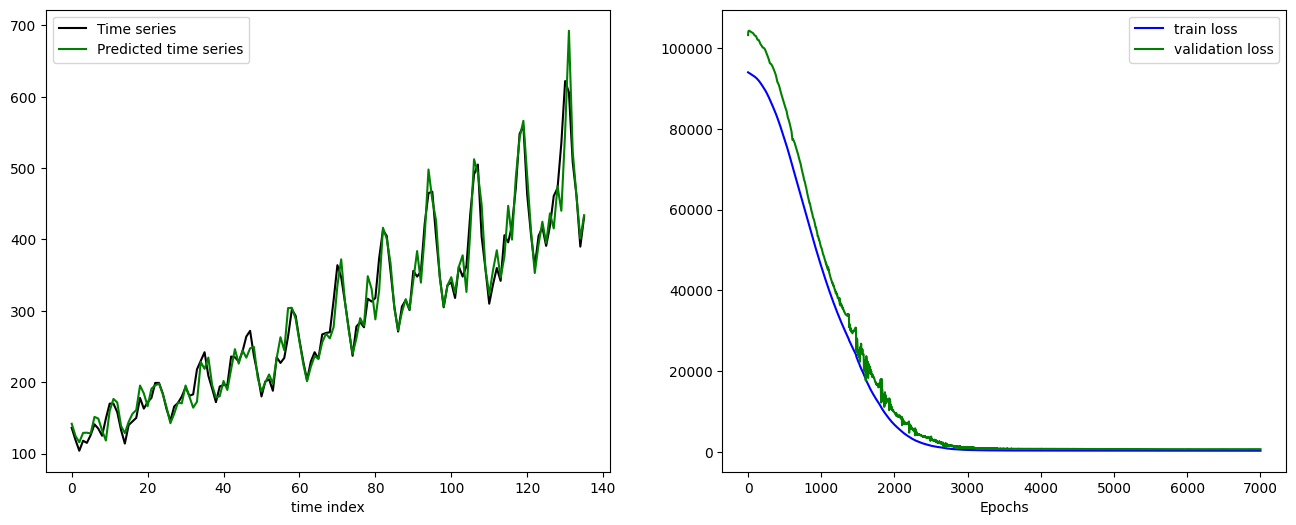

In [8]:
model.eval()
with torch.no_grad():
    y_pred_ts = model(Xdata)

print(Ydata.shape, y_pred_ts.shape)
# plot result
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].plot(Ydata,color ='k',label='Time series')
axs[0].plot(y_pred_ts,color='g',label='Predicted time series')
axs[0].set_xlabel('time index')
axs[0].legend()


axs[1].plot(np.array(loss_train), color = 'b', label = 'train loss')
axs[1].plot(np.array(loss_val), color = 'g', label = 'validation loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()
plt.show()

In [9]:
class SimpleDataSetLSTM(Dataset):
    def __init__(self, x_data, y_data, h_data, transform=None, target_transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.h_data = h_data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        x = self.x_data[idx, :]
        y = self.y_data[idx]
        h = self.h_data[idx, :]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y, h


train_dl_lstm = DataLoader(SimpleDataSetLSTM(Xtrain, Ytrain, Htrain), batch_size=n_batch, shuffle= True)
val_dl_lstm = DataLoader(SimpleDataSetLSTM(Xval, Yval, Hval), batch_size=n_batch, shuffle= True)

In [10]:
class LSTMWithEncoder(nn.Module):
    def __init__(self, hidden_size, n_encoder=20):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in, n_out: nn.Sequential(nn.Linear(n_in, 40), nn.ReLU(),
                                                nn.Linear(40, n_out))  # short hand for a 1 hidden layer NN
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=hidden_size, batch_first=True)
        self.h2o = net(hidden_size + self.input_size, self.output_size)  # i)
        self.encoder = net(n_encoder, hidden_size)

    def forward(self, inputs, hist):
        # inputs: [n_batch, n_sequence] (assumed 1 feature)
        # hist: [n_batch, n_encoder]
        h_0 = self.encoder(hist)[None, :, :] # [1, n_batch, self.hidden_size]
        c_0 = torch.zeros(h_0.shape) # [1, n_batch, self.hidden_size]

        # 1 layer LSTM with batch_first = True expects
        # INPUTS
        # input --> (n_batch, n_sequence, n_features)
        # h_0 --> (n_layer=1,n_batch, n_hidden)
        # c_0 --> (n_layer=1,n_batch, n_hidden)
        # OUTPUTS
        # hiddens: [n_batch, n_sequence, self.hidden_size]
        # Each hidden state is a vector of size self.hidden_size, representing the learned representation at each time step (n_sequence).
        # h_n: [self.output_size, n_features, self.hidden_size]
        hiddens, (h_n, c_n) = self.lstm(inputs[:, :, None], (h_0, c_0))

        # combined creates a feature vector which is the combination of the input + learned representation output from LSTM
        combined = torch.cat((hiddens, inputs[:, :, None]), dim=2) # [n_batch, n_sequence, n_hidden + n_features]

        # Since self.h2o predicts on the elements in last dimension, we can loop here by using `view`
        # For example, view [5,10,8] as [50,8] to get an output of shape [50, self.output_size], then reshape it back to [5, 10, self.output_size]
        h2o_input = combined.view(-1, self.hidden_size + self.input_size) # [n_batch * n_sequence, n_hidden + n_features]
        y_predict = self.h2o(h2o_input).view(inputs.shape[0], inputs.shape[1]) # [n_batch, n_sequence]
        return y_predict[:,-1] # Use the last output from the sequence as the output


model_lstm = LSTMWithEncoder(hidden_size=40, n_encoder=n_hist)
# Create model
print(f"model structure: {model_lstm}\n\n")

model structure: LSTMWithEncoder(
  (lstm): LSTM(1, 40, batch_first=True)
  (h2o): Sequential(
    (0): Linear(in_features=41, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
  )
)




In [11]:
def train_loop_lstm(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y, h) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X, h)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss = loss.item()
    return loss


def test_loop_lstm(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y, h in dataloader:
            pred = model(X, h)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [12]:
optimizer_lstm = torch.optim.Adam(model_lstm.parameters())
epochs = 7001
loss_train_lstm= []
loss_val_lstm = []
for t in range(epochs):
    loss_t = train_loop_lstm(train_dl_lstm, model_lstm, loss_fn, optimizer_lstm)
    loss_v = test_loop_lstm(val_dl_lstm, model_lstm, loss_fn)
    loss_train_lstm.append(loss_t)
    loss_val_lstm.append(loss_v)

    if t % 500 == 0:
        print(f"Epoch {t+1}, Train loss = {loss_t}, Validation loss = {loss_v} \n-------------------------------")

Epoch 1, Train loss = 87494.484375, Validation loss = 97090.734375 
-------------------------------
Epoch 501, Train loss = 1181.054443359375, Validation loss = 1122.687255859375 
-------------------------------
Epoch 1001, Train loss = 1140.299560546875, Validation loss = 1185.0150146484375 
-------------------------------
Epoch 1501, Train loss = 1071.1085205078125, Validation loss = 1287.173583984375 
-------------------------------
Epoch 2001, Train loss = 1017.5609130859375, Validation loss = 1369.7142333984375 
-------------------------------
Epoch 2501, Train loss = 955.5234985351562, Validation loss = 1396.6905517578125 
-------------------------------
Epoch 3001, Train loss = 870.5125122070312, Validation loss = 1514.024169921875 
-------------------------------
Epoch 3501, Train loss = 800.3088989257812, Validation loss = 1596.9534912109375 
-------------------------------
Epoch 4001, Train loss = 707.068603515625, Validation loss = 1697.8892822265625 
-----------------------

torch.Size([136]) torch.Size([136])


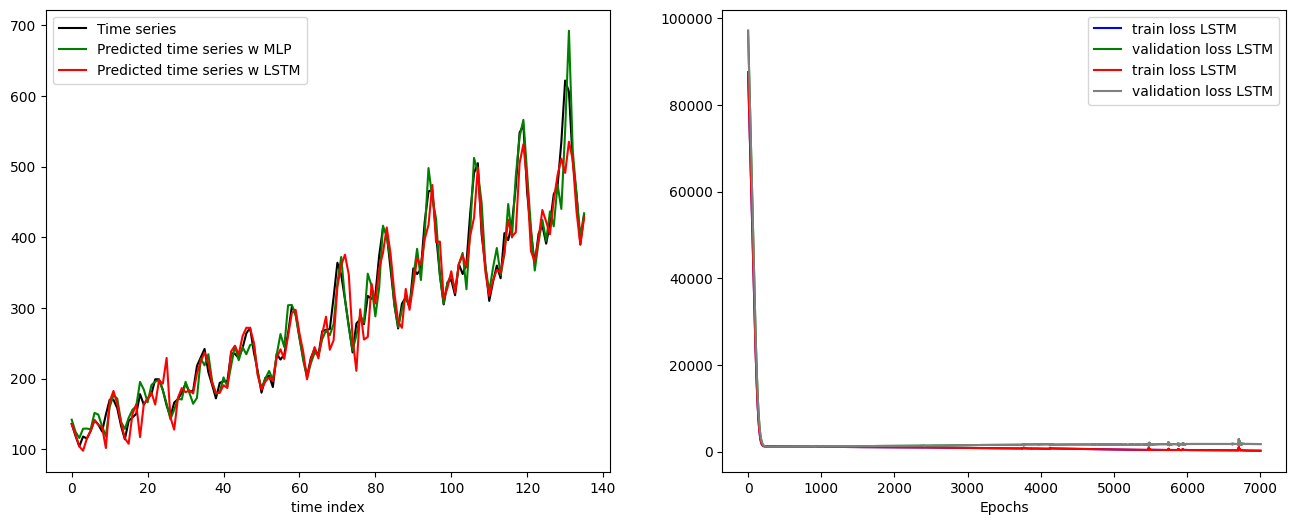

In [17]:
model_lstm.eval()
with torch.no_grad():
    y_pred_ts_lstm = model_lstm(Xdata, Hdata)

print(Ydata.shape, y_pred_ts_lstm.shape)
# plot result
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].plot(Ydata,color ='k',label='Time series')
axs[0].plot(y_pred_ts,color='g',label='Predicted time series w MLP')
axs[0].plot(y_pred_ts_lstm,color='r',label='Predicted time series w LSTM')
axs[0].set_xlabel('time index')
axs[0].legend()


axs[1].plot(np.array(loss_train_lstm), color = 'b', label = 'train loss LSTM')
axs[1].plot(np.array(loss_val_lstm), color = 'g', label = 'validation loss LSTM')
axs[1].plot(np.array(loss_train_lstm), color = 'r', label = 'train loss LSTM')
axs[1].plot(np.array(loss_val_lstm), color = (0.5,0.5,0.5), label = 'validation loss LSTM')
axs[1].set_xlabel('Epochs')
axs[1].legend()
plt.show()